In [25]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import numpy as np
import torch

from noise import get_noised_images


# Generate noise

In [26]:
from noise import load_image, draw_noise_evolution

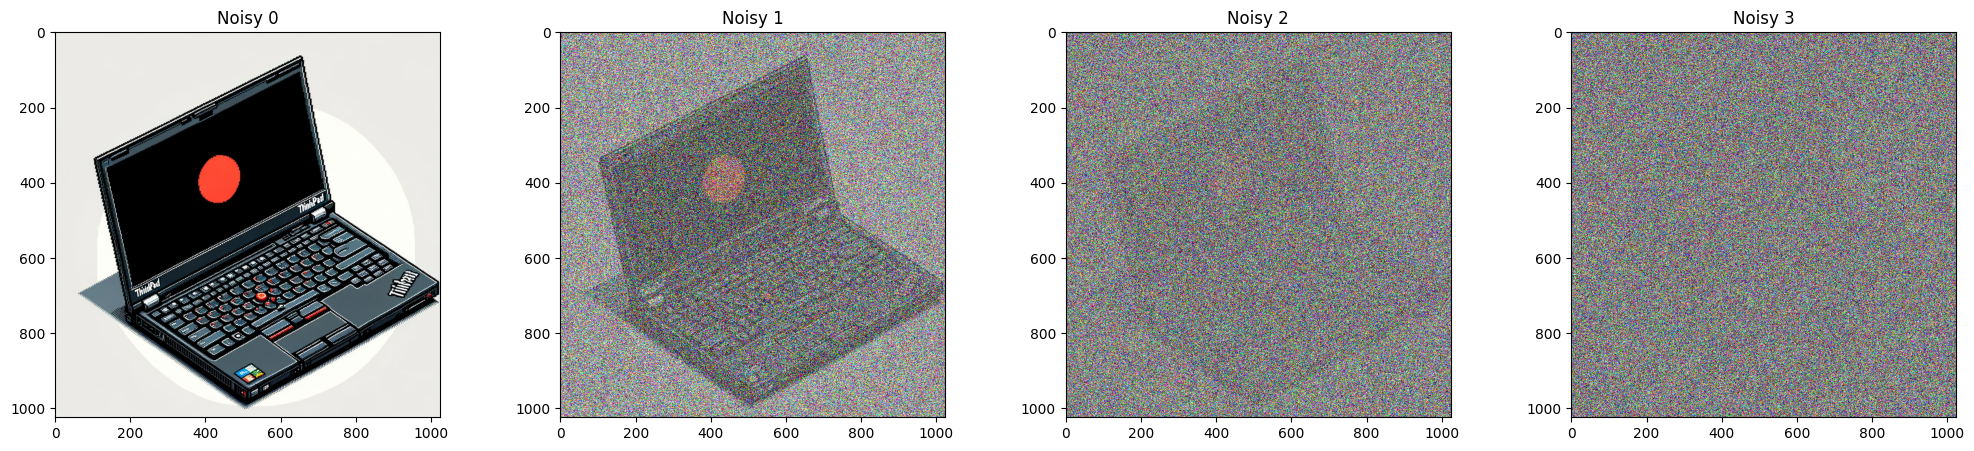

In [27]:
image = load_image("images/ThinkPad_1024.png")

draw_noise_evolution(image, 4, 1.8, "images/noise.png")


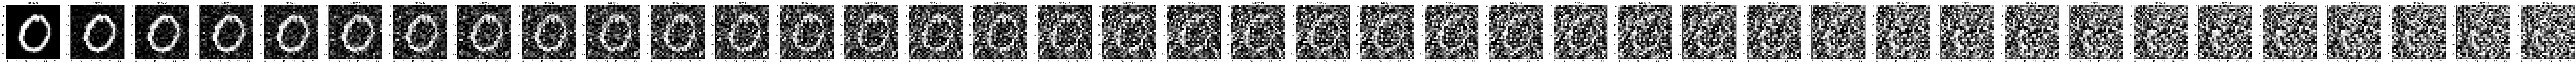

In [28]:
# n = 4
# noise = 0.5
# for i in range(0, 10, 2):
#     image = load_image(f"data/{i}/{i+1}.png")

#     draw_noise_evolution(image, n, noise)


n = 40
noise = 0.12
for i in range(0, 10, 2):
    image = load_image(f"data/{i}/{i+1}.png")

    draw_noise_evolution(image, n, noise)
    break


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"  # TMP
print("Device:", device)


Device: cuda


# Preparing dataset

In [30]:
class NoisedDataset(Dataset):
    def __init__(self, dataset, n: int = 4, noise: float = 0.5) -> None:
        self.dataset = dataset
        self.n = n
        self.noise = noise
        self.classes = dataset.classes

    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, idx: int) -> tuple:
        image, label = self.dataset[idx]
        noised_images = get_noised_images(image, self.n, self.noise)
        noised_images = torch.stack(noised_images)

        return noised_images, label


In [31]:
IMG_SIZE = 64

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root="data/1/", transform=transforms.ToTensor())
dataset = NoisedDataset(dataset, n, noise)

dataloader = DataLoader(dataset, batch_size=5, shuffle=True)

print("Classes:", len(dataset.classes))
print("Records:", len(dataset))


Classes: 1
Records: 10


In [32]:
for images, labels in dataloader:
    print(len(images))  # 5 - batch size
    print(len(images[0]))  # 4 - image + 3 noised images
    print(len(labels))  # 5 - labels
    break


5
40
5


In [33]:
class ImageModel(nn.Module):
    def __init__(self, input_channels: int = 3, output_channels: int = 3, image_size: tuple[int, int] = (28, 28)) -> None:
        super(ImageModel, self).__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.image_size = image_size

        # Rozszerzony model zawiera więcej warstw i kanałów
        self.conv1 = nn.Conv2d(in_channels=self.input_channels, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)  # Dodatkowa warstwa
        
        # Warstwy transponowane konwolucyjne, odpowiadające rozszerzeniu
        self.t_conv1 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.t_conv2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.t_conv3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.t_conv4 = nn.ConvTranspose2d(in_channels=32, out_channels=self.output_channels, kernel_size=3, stride=1, padding=1)  # Dodatkowa warstwa

    def forward(self, x):
        # Przechodzimy przez warstwy konwolucyjne
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))  # Przejście przez dodatkową warstwę
        
        # Przechodzimy przez warstwy transponowane konwolucyjne
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        x = torch.sigmoid(self.t_conv4(x))  # Używamy sigmoid, aby wyjście było między 0 a 1

        return x


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


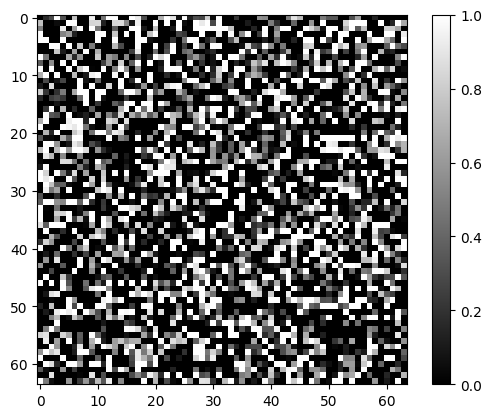

In [34]:
noise = np.random.normal(0.1, 1, (IMG_SIZE, IMG_SIZE))
noise = np.stack([noise, noise, noise], axis=-1)

plt.imshow(noise, cmap="gray")
plt.colorbar()
plt.show()


In [35]:
def generate_image(model, height=28, width=28):
    noise = np.random.normal(0.1, 1, (height, width))
    noise = np.stack([noise, noise, noise], axis=0)
    noise = torch.tensor(noise, device=device).float().unsqueeze(0)

    # Generowanie obrazu za pomocą modelu
    with torch.no_grad():  # Włączenie trybu bez obliczania gradientów
        generated_image = model(noise)#.numpy()

    # Normalizacja obrazu do zakresu [0, 1] dla poprawnego wyświetlenia
    # Zakładamy, że obraz jest generowany z zakresu [-1, 1] lub podobnego
    generated_image = (generated_image - generated_image.min()) / (generated_image.max() - generated_image.min())

    # Usuwanie pierwszego wymiaru (batch size), który jest równy 1
    generated_image = generated_image.squeeze(0).cpu().numpy()
    return generated_image


def display_generated_images(model, images_to_generate=5, height=28, width=28):
    model.eval()
    plt.figure(figsize=(10, 2))
    for i in range(images_to_generate):
        generated_image = generate_image(model, height=height, width=width)
        plt.subplot(1, images_to_generate, i+1)
        
        # Obrazy są w formacie [channels, height, width], więc trzeba je przekształcić do [height, width, channels]
        plt.imshow(np.transpose(generated_image, (1, 2, 0)))
        plt.axis("off")
    plt.show()
    model.train()


In [36]:
lr = 0.00001

model = ImageModel(image_size=(IMG_SIZE, IMG_SIZE))
# model = torch.load("50epochs.pth")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()


In [37]:
# from simple_unet import UNet

# model = UNet(3, 3)
# model.to(device)


In [38]:
def display_images_side_by_side(input_images, target_images, num_images=5):
    # Ustawienie liczby obrazów do wyświetlenia na minimum między num_images a faktyczną liczbą obrazów w batchu
    num_images = min(num_images, input_images.size(0))

    plt.figure(figsize=(2 * num_images, 4))  # Ustawienie rozmiaru figury

    for idx in range(num_images):
        # Wyświetlanie input_images
        plt.subplot(2, num_images, idx + 1)
        img = input_images[idx].cpu().detach()
        img = img.permute(1, 2, 0).numpy()  # Zmiana CxHxW na HxWxC dla matplotlib
        plt.imshow((img - img.min()) / (img.max() - img.min()))  # Normalizacja do [0,1]
        plt.axis('off')

        # Wyświetlanie target_images
        plt.subplot(2, num_images, num_images + idx + 1)
        img = target_images[idx].cpu().detach()
        img = img.permute(1, 2, 0).numpy()  # Zmiana CxHxW na HxWxC dla matplotlib
        plt.imshow((img - img.min()) / (img.max() - img.min()))  # Normalizacja do [0,1]
        plt.axis('off')

    plt.show()

1 row: what I give
2 row: what I expect


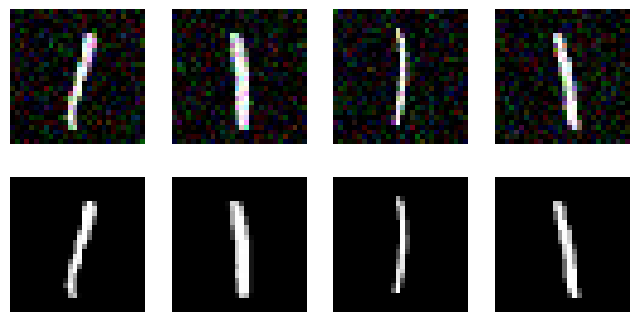

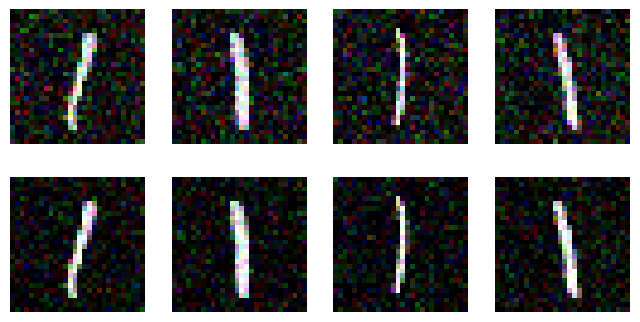

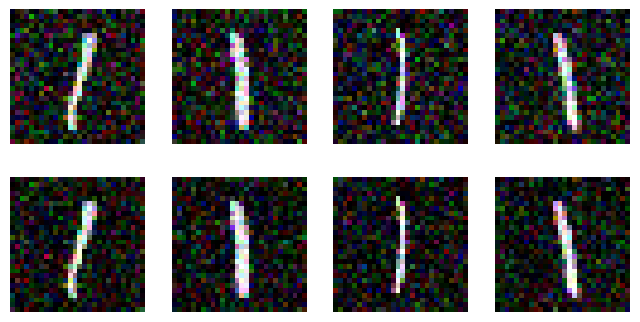

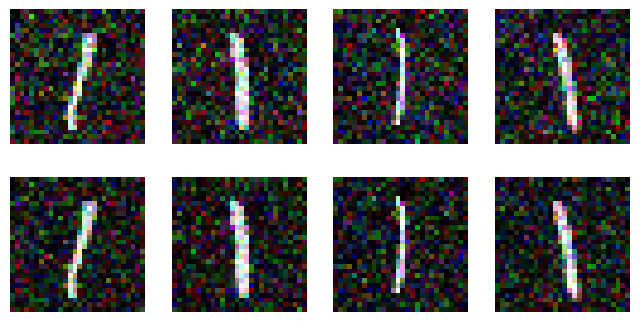

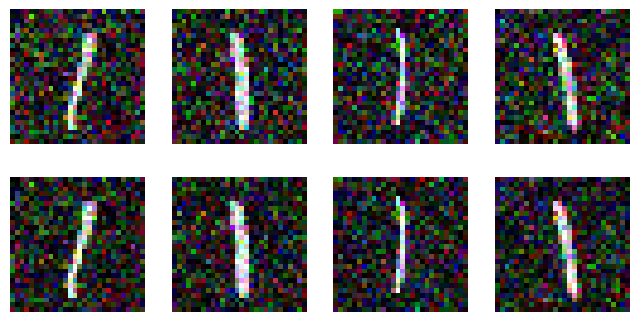

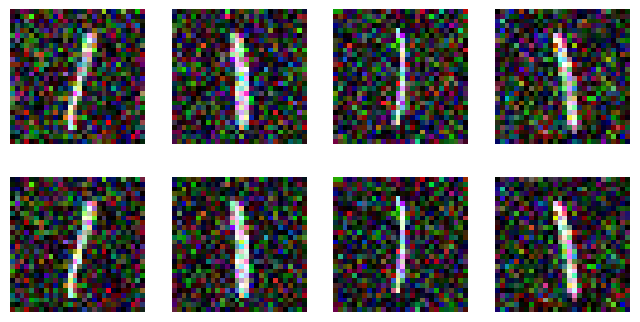

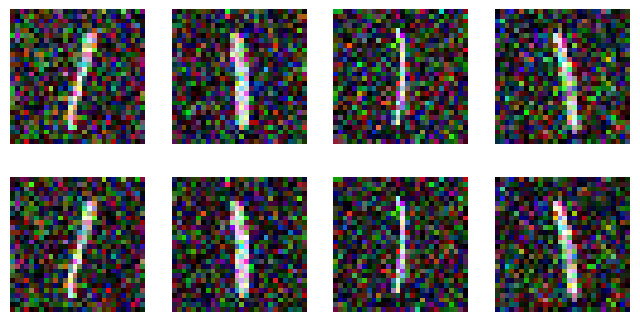

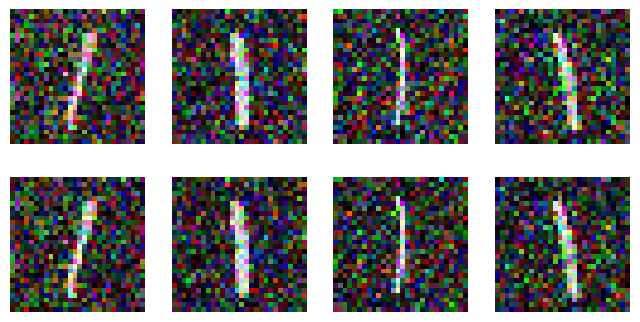

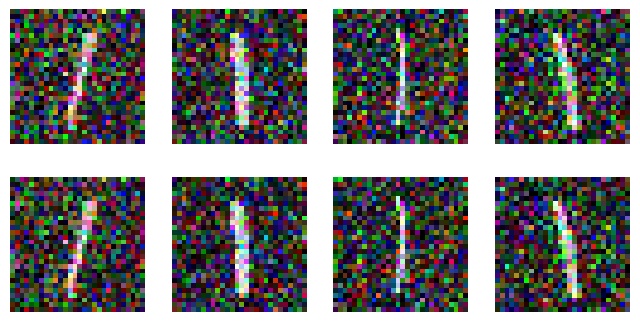

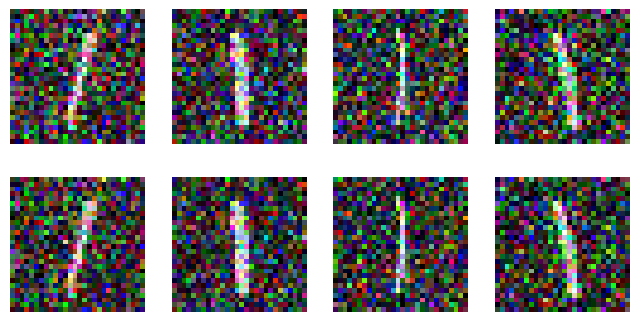

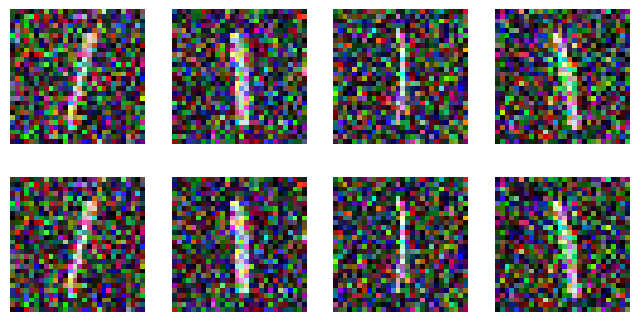

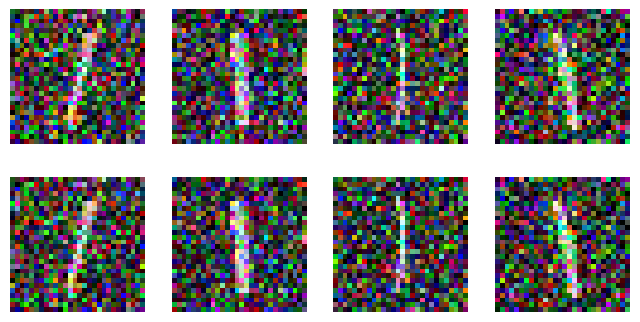

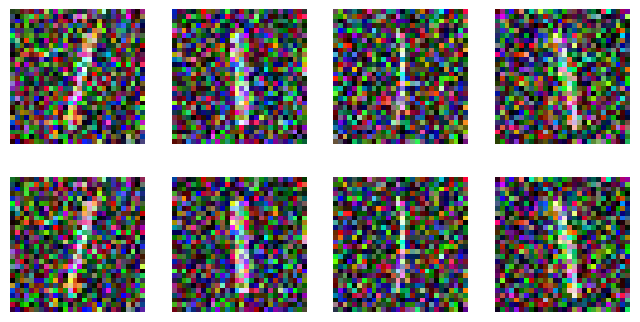

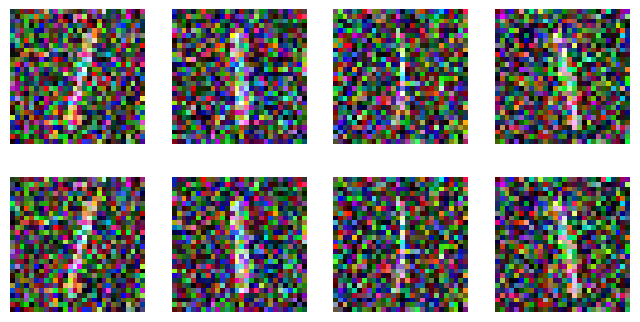

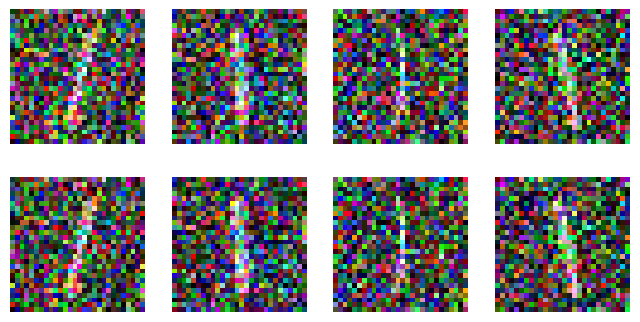

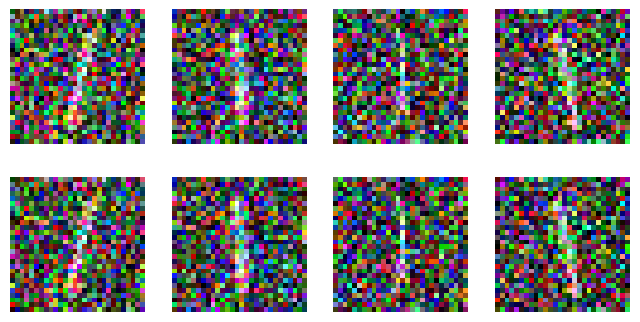

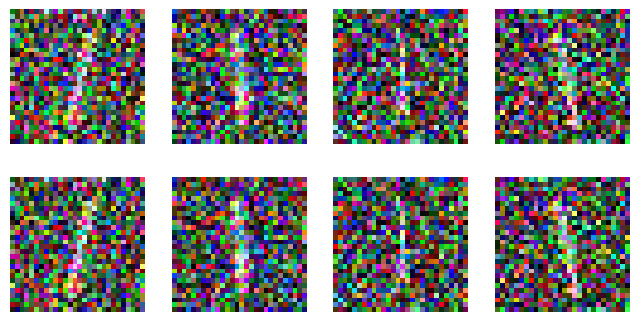

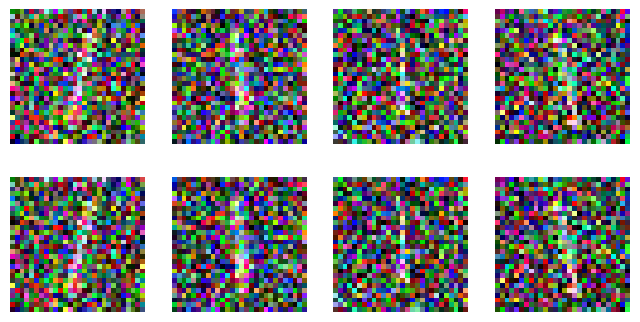

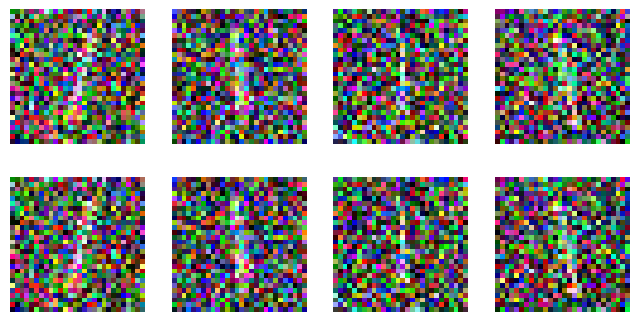

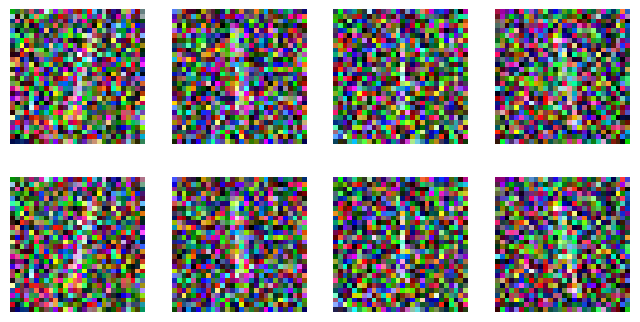

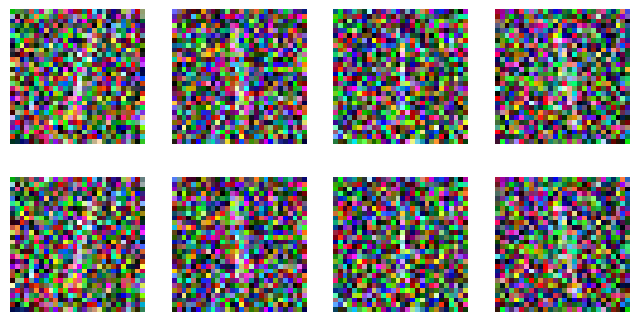

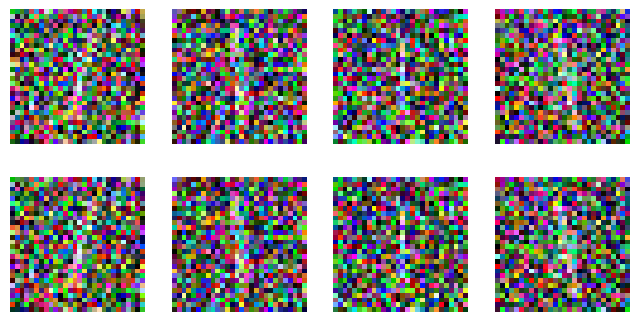

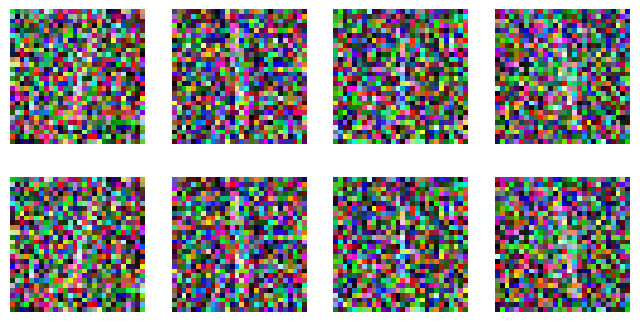

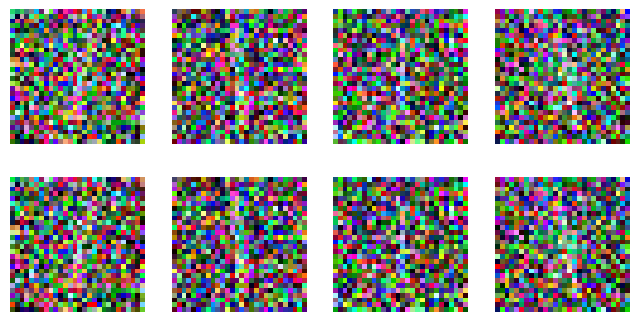

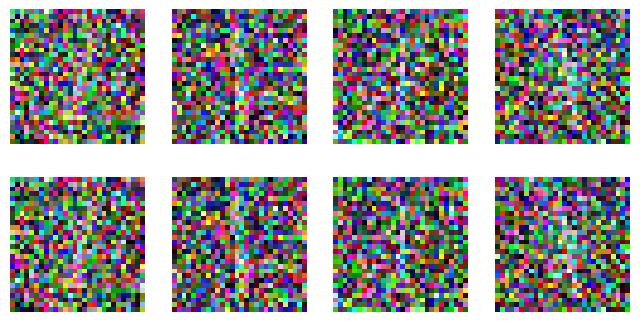

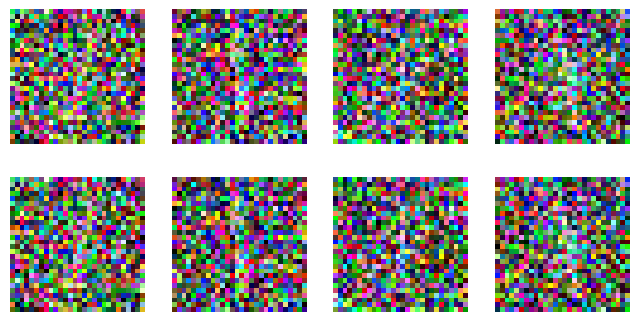

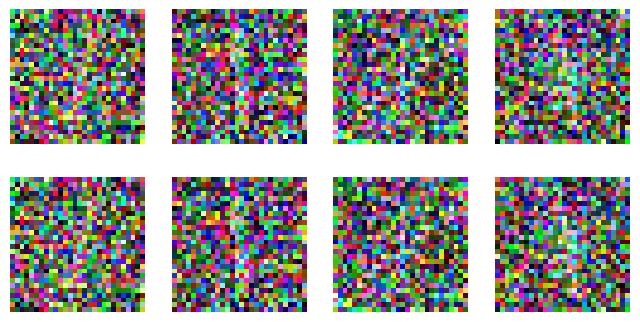

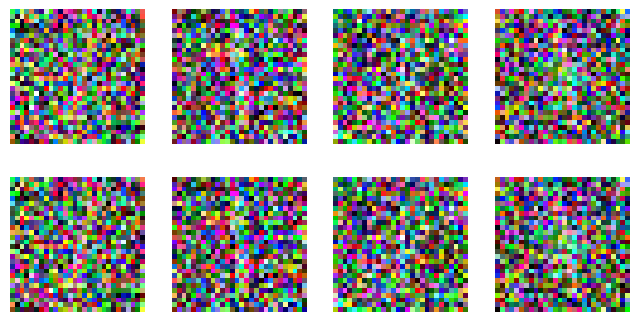

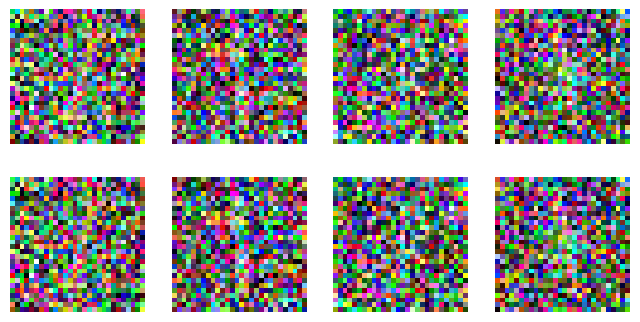

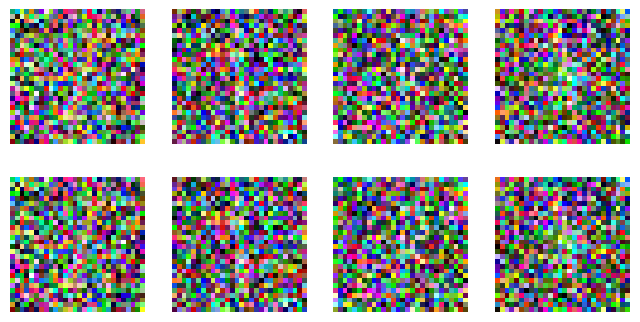

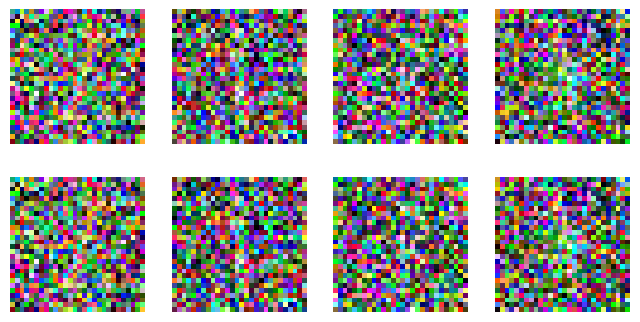

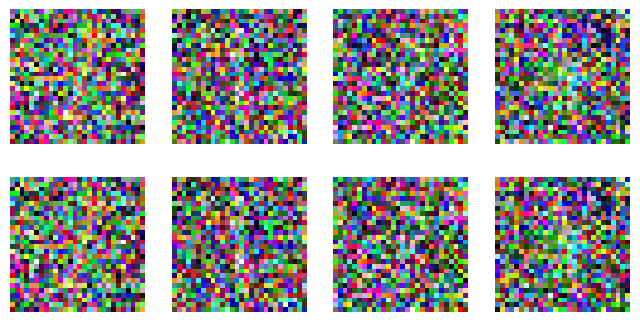

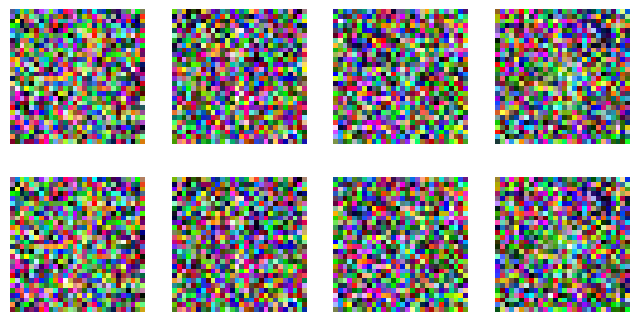

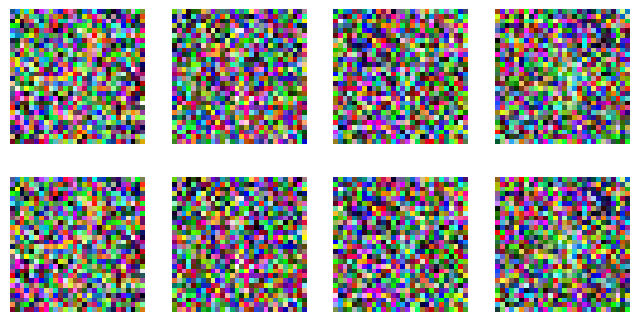

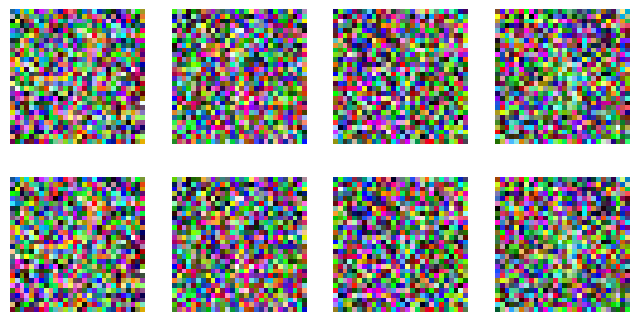

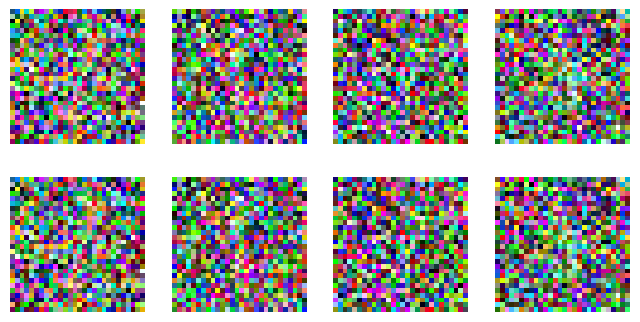

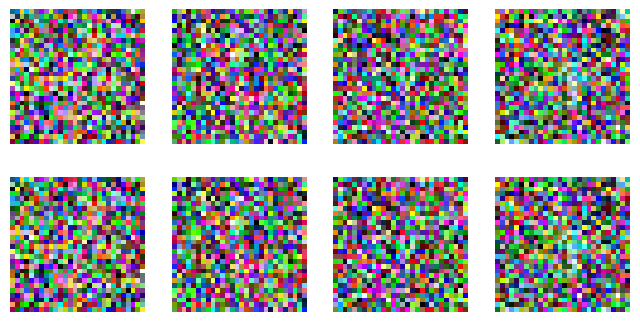

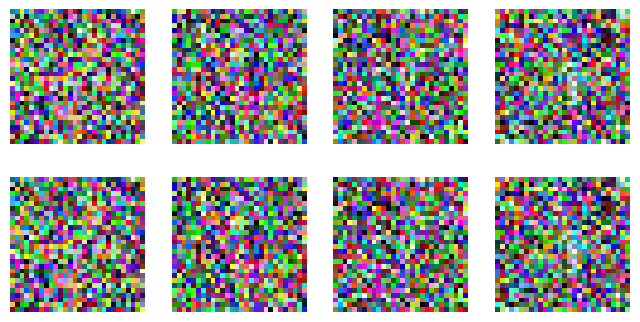

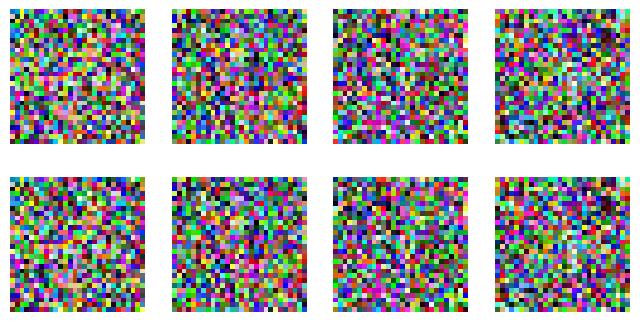

Epoch 100, Loss: 0.10255806148052216


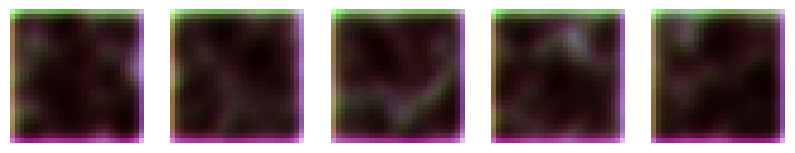

Epoch 200, Loss: 0.09164050221443176


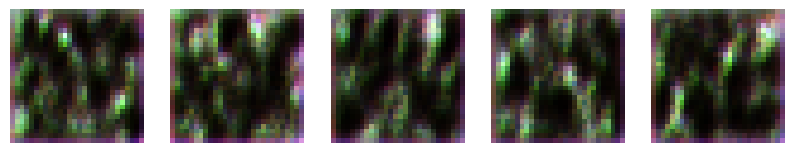

Epoch 300, Loss: 0.0677812248468399


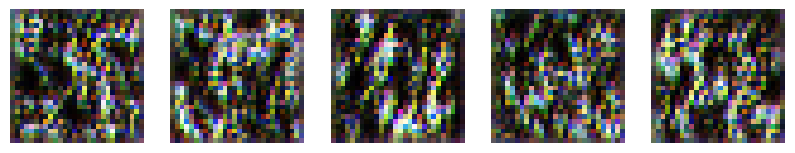

Epoch 400, Loss: 0.04461619257926941


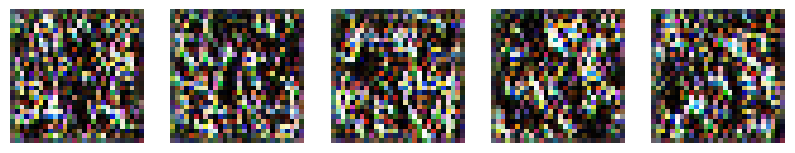

KeyboardInterrupt: 

In [39]:
first_batch = True
num_epochs = 5_000

print("1 row: what I give")
print("2 row: what I expect")

model.train()
for epoch in range(num_epochs):
    for batch in dataloader:
        optimizer.zero_grad()
        images, _ = batch
        images = images.to(device).float()

        for i in range(1, len(images[0])):
            input_images = torch.stack([img[i] for img in images])  # Tworzy batch dla bieżącej transformacji
            target_images = torch.stack([img[i-1] for img in images])  # Tworzy batch dla poprzedniej transformacji jako cel
            if first_batch:
                display_images_side_by_side(input_images, target_images, 4)

            output_images = model(input_images)
            
            loss = criterion(output_images, target_images)
            loss.backward()
        first_batch = False

        optimizer.step()

    if (epoch+1)%100 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")
        display_generated_images(model)


In [ ]:

torch.save(model, "Xepochs.pth")
